In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm import tqdm

In [411]:
train_data=np.load('Assign1/Data/data0.npy')
train_labels=np.load('Assign1/Data/lab0.npy')
# for i in range(1,3):
#     temp_data = np.load(f'Assign1/Data/data{i}.npy')
#     temp_label = np.load(f'Assign1/Data/lab{i}.npy')
#     train_data = np.concatenate((train_data,temp_data))
#     train_labels = np.concatenate((train_labels,temp_label))
print(train_data.shape,train_labels.shape)

(10000, 40, 168) (10000,)


In [442]:
def seg_image(img):
    w,h = int(168*1.5),int(40*1.5)
    img = cv2.resize(img,(w, h))
    gray = cv2.copyMakeBorder(img, 8, 8, 8, 8, cv2.BORDER_REPLICATE)
    gray = cv2.resize(gray,(w, h))
    kernel = np.ones((2, 2), np.uint8) 
    gray = cv2.erode(gray, kernel)
    letter_image_regions = []
 
    # finding the contours
    contours, hierarchy = cv2.findContours(gray.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2:]
    for contour in contours:
      # Get the rectangle that contains the contour
      (x, y, w, h) = cv2.boundingRect(contour)

      # checking if any counter is too wide
      # if countour is too wide then there could be two letters joined together or are very close to each other
      if w / h > 1.25:
        # Split it in half into two letter regions
        half_width = int(w / 2)
        letter_image_regions.append((x, y, half_width, h))
        letter_image_regions.append((x + half_width, y, half_width, h))
      else:  
        letter_image_regions.append((x, y, w, h))
    letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])
    segmentation = []
    for i in range(len(letter_image_regions)):
        x,y,w,h = letter_image_regions[i]
#         print(w*h)
        if w*h > 100:
#             img_dil = cv2.dilate(gray[y - 2:y + h + 2, x - 2:x + w + 2],kernel)
            img_dil = gray[y - 2:y + h + 2, x - 2:x + w + 2]
            segmentation.append(cv2.dilate(img_dil,kernel))
#             segmentation.append(gray[y:y + h, x :x + w ])
    return segmentation

17


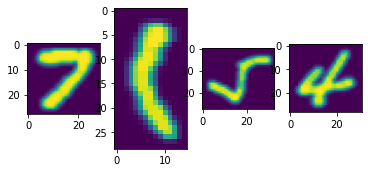

In [446]:
ind = 48
img = train_data[ind]
segs = seg_image(img)
zero = segs[-1]
print(train_labels[ind])
for i in range(len(segs)):
    plt.subplot(1,len(segs),i+1)
    plt.imshow(segs[i])

This will be a 2 step process. We first train a simple model capable of doing MNIST digit recognition. Then we take 4 instances of this model and pass our 4 outputs through them and the output is taken as an input vector to the final layer. The output of the final layer is our answer which is compared with the label that we have. We first train the model and then train the whole thing end 2 end.

In [447]:
class CFG:
    batch_size=128
    momentum_value = 0.9
    epochs=50
    lr = 1e-2
    seed = 42
    num_workers=4
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model_name='custom'
    valid_size = 0.3
    size=28

In [458]:
torch.manual_seed(CFG.seed)
RandAffine = transforms.RandomAffine(degrees=45, translate=(0.1, 0.1), scale=(0.8, 1.2))


train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
#         RandAffine,
        transforms.Normalize((0.1307,), (0.3081,)),
#         transforms.RandomErasing(p=0.3)
        ])),
    batch_size=CFG.batch_size, shuffle=True, num_workers=CFG.num_workers)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])),
     batch_size=CFG.batch_size, shuffle=True, num_workers=CFG.num_workers)

In [459]:
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel,self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(1,10,kernel_size=5),
                                   nn.MaxPool2d(2,2),
                                   nn.ReLU(inplace=True))
        self.layer2 = nn.Sequential(nn.Conv2d(10,20,kernel_size=5),
                                   nn.MaxPool2d(2,2),
                                   nn.ReLU(inplace=True))
        self.fc1 = nn.Sequential(nn.Linear(320,50),
                                 nn.ReLU(inplace=True))
        self.fc2 = nn.Linear(50,10)
    def forward(self,x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(-1,320)
        x = self.fc1(x)
        x = self.fc2(x)
        return F.log_softmax(x)
class BatchModel(nn.Module):
    def __init__(self):
        super(BatchModel,self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(1,128,kernel_size=3,padding=1),
                                   nn.ReLU(inplace=True),
                                   nn.BatchNorm2d(num_features=128),
                                   nn.Conv2d(128,4,kernel_size=1,padding=1))
        self.layer2 = nn.Sequential(nn.Conv2d(4,16,kernel_size=3,padding=1),
                                   nn.ReLU(inplace=True),
                                   nn.BatchNorm2d(num_features=16),
                                   nn.Dropout2d(0.1))
        self.layer3 = nn.Sequential(nn.Conv2d(16,16,kernel_size=3,padding=1),
                                   nn.ReLU(inplace=True),
                                   nn.BatchNorm2d(num_features=16),
                                   nn.Dropout2d(0.1))
        self.layer4 = nn.Sequential(nn.Conv2d(16,32,kernel_size=3,padding=1),
                                   nn.ReLU(inplace=True),
                                   nn.BatchNorm2d(num_features=32),
                                   nn.Dropout2d(0.1))
        self.trn2 = nn.Conv2d(32,16,kernel_size=1,padding=1)
        self.pool1 = nn.MaxPool2d(2,2)
        self.pool2 = nn.MaxPool2d(2,2)
        self.layer5 = nn.Sequential(nn.Conv2d(16,32,kernel_size=3,padding=1),
                                   nn.ReLU(inplace=True),
                                   nn.BatchNorm2d(num_features=32),
                                   nn.Dropout2d(0.1))
        self.layer6 = nn.Sequential(nn.Conv2d(32,64,kernel_size=3,padding=1),
                                   nn.ReLU(inplace=True),
                                   nn.BatchNorm2d(num_features=64),
                                   nn.Dropout2d(0.1))
        self.layer7 = nn.Conv2d(64,10,kernel_size=1,padding=1)
        self.gpool = nn.AvgPool2d(kernel_size=7)
        
    def forward(self,x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.pool1(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.trn2(self.pool2(x))
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.gpool(x)
        x = x.view(-1,10)
        return F.log_softmax(x)
    
from torchvision.models.resnet import ResNet, BasicBlock, Bottleneck

class MNISTResNet(ResNet):
    def __init__(self):
        super(MNISTResNet, self).__init__(BasicBlock, [2, 2, 2, 2], num_classes=10) # Based on ResNet18
        # super(MNISTResNet, self).__init__(BasicBlock, [3, 4, 6, 3], num_classes=10) # Based on ResNet34
        # super(MNISTResNet, self).__init__(Bottleneck, [3, 4, 6, 3], num_classes=10) # Based on ResNet50
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=1, padding=3,bias=False)
class AverageMeter(object):
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        
    def update(self,val,n=1):
        self.val += val
        self.sum += val*n
        self.count += n
        self.avg = self.sum/self.count

In [460]:
model = BatchModel()
model = model.to(CFG.device)
optimizer = optim.Adam(model.parameters(),lr=CFG.lr)
criterion = nn.CrossEntropyLoss()

In [461]:
from tqdm import tqdm
def train(model,train_loader, optimizer,criterion, epoch):
    train_loss = AverageMeter()
    model.train()
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(CFG.device), target.to(CFG.device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'epoch: {epoch} loss={loss.item()} batch_id={batch_idx}')
        train_loss.update(loss.item())
    return train_loss.avg

def test(model, criterion,test_loader):
    model.eval()
    test_loss = AverageMeter()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(CFG.device), target.to(CFG.device)
            output = model(data)
            test_loss.update(criterion(output, target).item())
            pred = output.argmax(dim=1, keepdim=True)
            correct +=pred.eq(target.view_as(pred)).sum().item()
#     test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{}({:.1f}%)\n'.format(test_loss.avg, correct,\
          len(test_loader.dataset), 100. * correct /
          len(test_loader.dataset)))
    return test_loss.avg

In [ ]:
OUTPUT_DIR = './'
train_losses = []
test_losses = []
best_loss = np.Inf
for epoch in range(1, CFG.epochs):
    train_losses.append(train(model, train_loader, optimizer,criterion, epoch))
    testy_loss = test(model,criterion, test_loader)
    test_losses.append(testy_loss)
    if testy_loss < best_loss:
        best_loss = testy_loss
        print("Saving Model")
        torch.save({'model': model.state_dict()},
                    OUTPUT_DIR+f'{CFG.model_name}_best.pth')

  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0469, Accuracy: 9843/10000(98.4%)

Saving Model


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0383, Accuracy: 9880/10000(98.8%)

Saving Model


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0272, Accuracy: 9912/10000(99.1%)

Saving Model


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9918/10000(99.2%)

Saving Model


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9923/10000(99.2%)

Saving Model


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9924/10000(99.2%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9924/10000(99.2%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9913/10000(99.1%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9934/10000(99.3%)

Saving Model


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9918/10000(99.2%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9938/10000(99.4%)

Saving Model


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Accuracy: 9910/10000(99.1%)



epoch: 13 loss=0.0026078270748257637 batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 71.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0141, Accuracy: 9954/10000(99.5%)

Saving Model


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9932/10000(99.3%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9931/10000(99.3%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9928/10000(99.3%)



epoch: 17 loss=0.01000788901001215 batch_id=320:  68%|██████▊   | 320/469 [00:04<00:01, 78.03it/s]  

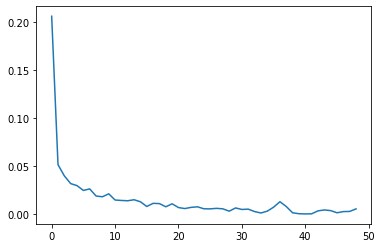

In [400]:
plt.plot(train_losses)

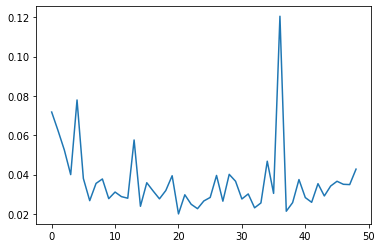

In [401]:
plt.plot(test_losses)

In [408]:
class CaptchaDataset(Dataset):
    def __init__(self,data,labels,dummy,transforms):
        super().__init__()
        self.data = data
        self.labels = labels
        self.transforms = transforms
        self.dummy = dummy
    
    def __len__(self):
        return self.labels.shape[0]
    
    def __getitem__(self,idx):
        img = self.data[idx]
        labels = self.labels[idx]
        segmented = seg_image(img)
        final = []
        if len(segmented) < 4:
            for i in range(4-len(segmented)):
                segmented.append(self.dummy)
        for i in range(len(segmented)):
            final.append(self.transforms(segmented[i]))
        return final,torch.tensor(labels)

In [280]:
num = train_data.shape[0]
indices = list(range(num))
np.random.seed(CFG.seed)
np.random.shuffle(indices)
split = int(np.floor(CFG.valid_size*num))
train_idx,valid_idx = indices[split:],indices[:split]

In [409]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((CFG.size,CFG.size)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset = CaptchaDataset(train_data,train_labels,zero,transform)
# val_dataset = CaptchaDataset(train_data[valid_idx],train_labels[valid_idx],zero,transform)

# train_sampler = SubsetRandomSampler(train_idx)
# valid_sampler = SubsetRandomSampler(valid_idx)

train_sum_loader = DataLoader(train_dataset, batch_size = 1)
valid_sum_loader = DataLoader(val_dataset, batch_size = CFG.batch_size)


In [266]:
class SumModel(nn.Module):
#     update on getting the latest model. rn we initialize the untrained one
    def __init__(self,checkpoint):
        super(SumModel,self).__init__()
        self.model = BaseModel()
        self.model.load_state_dict(checkpoint['model'])
        
    def forward(self,a,b,c,d):
        outputs = 0
        x = [a,b,c,d]
        for i in range(4):
            output = self.model(x[i])
            outputs += output.argmax(dim=1, keepdim=True)
        return outputs
        

In [406]:
checkpoint = torch.load(f'{CFG.model_name}_best.pth')
sum_model = MNISTResNet()
sum_model.load_state_dict(checkpoint['model'])
sum_model = sum_model.to(CFG.device)
# optimizer = optim.SGD(sum_model.parameters(),lr=CFG.lr,momentum=CFG.momentum_value)
# criterion = nn.MSELoss()

In [410]:
sum_model.eval()
test_loss = AverageMeter()
correct = 0
with torch.no_grad():
    for data, target in tqdm(train_sum_loader):
        target = target.to(CFG.device)
        outputs = 0
        for i in range(4):
            data[i] = data[i].to(CFG.device)
            output = sum_model(data[i])
            outputs += output.argmax(dim=1, keepdim=True)
#         outputs = outputs.flatten()
        if torch.unique(target==outputs).item():
            correct += 1
correct/len(train_dataset)*100

100%|██████████| 10000/10000 [02:12<00:00, 75.62it/s]


51.839999999999996